In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem.porter import *

# Download necessary NLTK resources
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')

In [2]:
lemmatizer = WordNetLemmatizer()

# Custom tokenizer that integrates NLTK lemmatization
def lemmatized_tokens(text):
    words = word_tokenize(text.lower())  # Tokenize and convert to lower case
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.isalnum()]  # Lemmatize and filter out non-alphanumeric tokens
    return lemmatized_words

# Function to vectorize texts and apply min_df filtering using CountVectorizer
def vectorize_texts(texts, min_df=0.001):
    vectorizer = CountVectorizer(tokenizer=lemmatized_tokens, min_df=min_df)
    X = vectorizer.fit_transform(texts)
    return vectorizer.get_feature_names_out()

In [2]:
import os
# Get the current working directory
current_dir = os.getcwd()
# Navigate to the parent folder
parent_dir = os.path.dirname(current_dir)

In [4]:
# Load the CSV file
file_path = os.path.join(parent_dir, 'New_turns.csv')
df_1 = pd.read_csv(file_path)

In [5]:
text_df = df_1.drop(['Person_id', 'Turn_id', 'Section_id', 'Speech_id'], axis=1)
text_df['Speech'] = text_df['Speech'].astype(str)
text_df = text_df.groupby('Doc_id')['Speech'].apply(' '.join).reset_index()

In [6]:
unique_words = vectorize_texts(text_df['Speech'])
print(unique_words)

d:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['0' '1' '10' ... 'zoom' 'zte' 'zurich']


In [8]:
unique_words_nonum = [word for word in unique_words if not any(char.isdigit() for char in word)]


In [9]:
with open('Unique_words.txt', 'w') as f:
    for item in unique_words_nonum:
        f.write("%s\n" % item)

In [6]:
with open('Unique_words.txt', 'r') as f:
    unique_words = [line.rstrip() for line in f]

In [7]:
sub_lists = [unique_words[i:i + 2000] for i in range(0, len(unique_words), 2000)]

In [8]:
for i, sublist in enumerate(sub_lists):
    with open(f'unique_words_{i}.txt', 'w') as f:
        for item in sublist:
            f.write("%s\n" % item)

Calculating the buzzscore

In [6]:
def count_buzzwords(df, text_column, buzzwords, doc_id_column):
    # Initialize a dictionary of dictionaries to store the counts for each document
    counts = {doc_id: {word: 0 for word in buzzwords} for doc_id in df[doc_id_column]}
    
    for _, row in df.iterrows():
        tokens = lemmatized_tokens(row[text_column])
        for i in range(1, len(tokens)):
            if tokens[i] in buzzwords:
                preceding_word = buzzwords[tokens[i]]
                if preceding_word is None or tokens[i-1] == preceding_word:
                    counts[row[doc_id_column]][tokens[i]] += 1
                
    # Convert the counts dictionary to a DataFrame
    counts_df = pd.DataFrame(counts).transpose()
    counts_df['buzzcount'] = counts_df.sum(axis=1)

    return counts_df

In [6]:
# Buzzwords
Buzzwords = {'agile': None, 'blockchain' : None, 'data' : 'big', 'crypto': None, 'cryptocurrency': None, 
             'decentralized': None, 'disruptive': None, 'web' : '3', 'revolutionairy' : None,
             'ecosystem': None, 'ai': None, 'artificial': 'intelligence', 'vr': None, 'virtual': 'reality',
             'ar': None, 'augmented': 'reality', 'leadership' : 'thought', 'visionary' : None, 'hyperautomation' : None,
             'metaverse' : None, 'cybersecurity' : None, 'cloud' : None, 'omnichannel' : None, 'sustainability' : None,
             'virtualization' : None, 'freemium' : None, 'fintech' : None, 'disruptor' : None, 'disruptive' : None,
             'decarbonization' : None, 'telematics' : None, 'technology' : 'disruptive', 'sustainable' : None,
             'learning' : 'deep', 'learning' : 'machine', 'learning' : 'reinforcement', 'learning' : 'supervised',
             'contracts' : 'smart', 'contracts' : 'blockchain', 'tech' : 'green', 'tech' : 'clean', 'tech' : 'sustainable',
             'iot' : None, 'computing' : 'edge', 'computing' : 'cloud', 'computing' : 'quantum', 'twin' : 'digital',
             'home' : 'smart', 'vision' : 'computer', 'experience' : 'employee', 'hacking' : 'growth', 'hypergrowth' : None,
             'tokenization' : None, 'capture' : 'carbon', 'logistics' : 'smart', 'finance' : 'green', 'paas': None,
             'taas' : None, 'medtech' : None, 'biotech' : None, 'healthtech' : None, 'insurtech' : None, 'edtech' : None,
             'wearables' : None, 'aiot' : None, 'defi' : None, 'nft' : None, 'web3' : None, 'rpa' : None, 'nlp' : None,
             'agi' : None}
buzzscore = count_buzzwords(text_df, 'Speech', Buzzwords, 'Doc_id')

In [15]:
print((buzzscore['buzzcount'] > 10).sum())

4281


In [3]:
file_path = os.path.join(parent_dir, 'Buzzword_count.csv')
buzzscore = pd.read_csv(file_path)

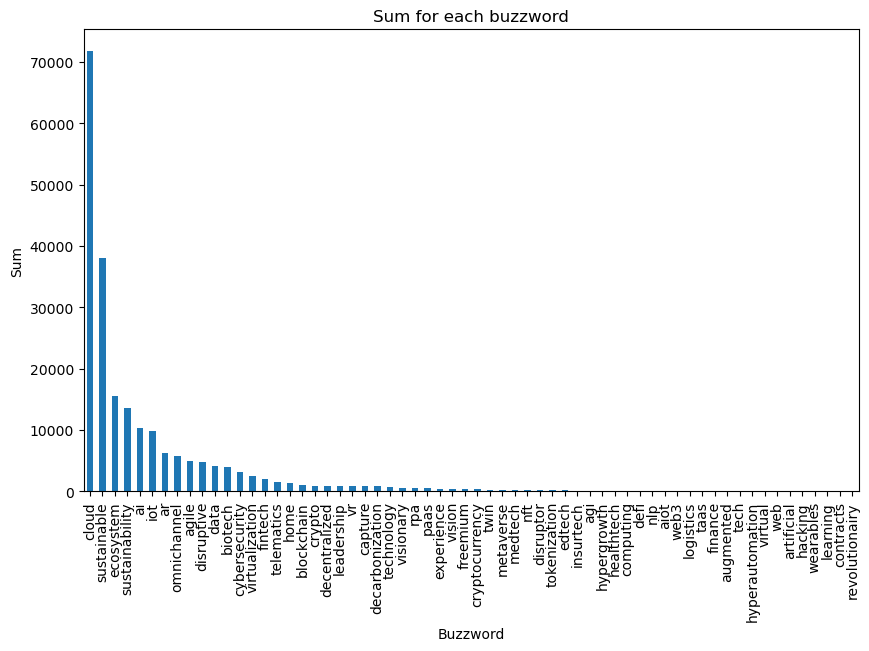

In [9]:
import matplotlib.pyplot as plt

# Filter the DataFrame to only include columns that are keys in the Buzzwords dictionary
filtered_df = buzzscore[list(Buzzwords.keys())]

# Calculate the sum for each column
column_sums = filtered_df.sum()

# Sort the sums in decreasing order
column_sums = column_sums.sort_values(ascending=False)

# Create a bar graph
plt.figure(figsize=(10, 6))
column_sums.plot(kind='bar')
plt.title('Sum for each buzzword')
plt.xlabel('Buzzword')
plt.ylabel('Sum')
plt.show()

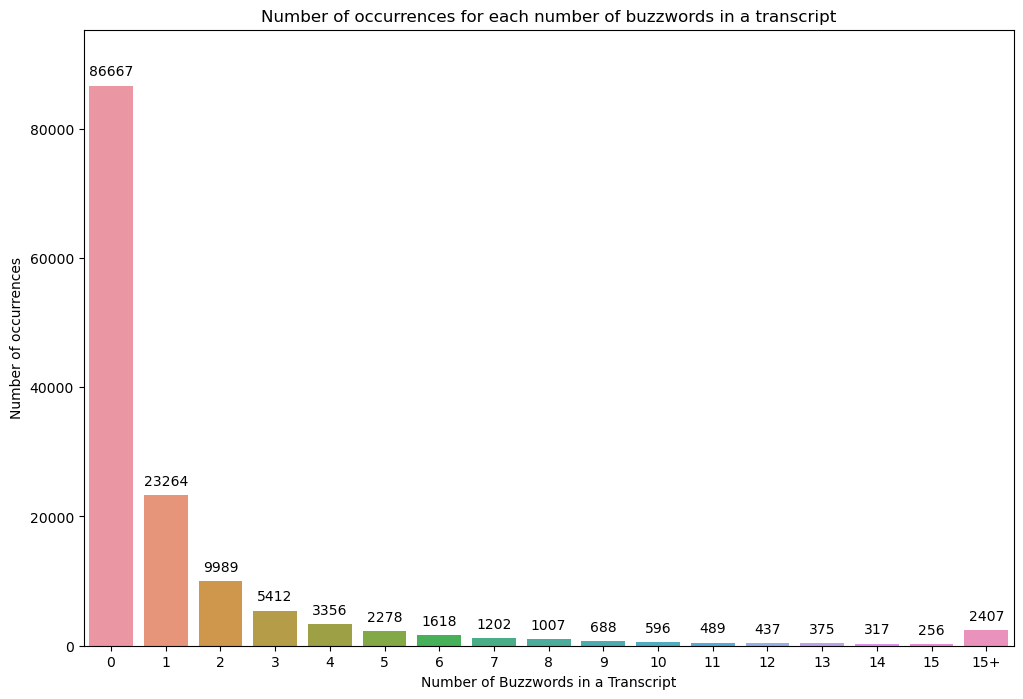

In [14]:
# Create a new column 'buzzcount_group' that groups 'buzzcount' values greater than 15 together
buzzscore['buzzcount_group'] = buzzscore['buzzcount'].apply(lambda x: '15+' if x > 15 else x)

# Count the number of occurrences for each 'buzzcount_group' value
buzzcount_counts = buzzscore['buzzcount_group'].value_counts()

# Sort the index by converting to integers where possible
buzzcount_counts.index = pd.to_numeric(buzzcount_counts.index, errors='coerce').astype('Int64')
buzzcount_counts = buzzcount_counts.sort_index()

# Convert the index back to strings, replacing 'nan' and '<NA>' with '15+'
buzzcount_counts.index = buzzcount_counts.index.to_series().astype(str).replace(['nan', '<NA>'], '15+')

import seaborn as sns

# Create a new DataFrame for plotting
buzzcount_df = buzzcount_counts.reset_index()
buzzcount_df.columns = ['Buzzcount', 'Number of occurrences']

# Create the bar plot with a larger figure size
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Buzzcount', y='Number of occurrences', data=buzzcount_df)

# Add the exact numbers on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 10), 
                     textcoords = 'offset points')

# Increase the y-axis limit based on the highest bar's height
plt.ylim(0, 1.1 * buzzcount_df['Number of occurrences'].max())

plt.title('Number of occurrences for each number of buzzwords in a transcript')
plt.xlabel('Number of Buzzwords in a Transcript')
plt.ylabel('Number of occurrences')
plt.show()

In [16]:
file_path = os.path.join(parent_dir, 'Buzzword_count.csv')
buzzscore.to_csv(file_path)

Calculating sentiment scores

In [6]:
sentiment_categories = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 
                             'Strong_Modal', 'Weak_Modal', 'Constraining']
file_path = os.path.join(parent_dir, 'Loughran-McDonald_MasterDictionary_1993-2023.csv')
sentiment_dict = pd.read_csv(file_path)

In [7]:
def tokenize(text):
    """Tokenize text and remove stopwords."""
    # Uppercase and tokenize
    tokens = word_tokenize(text.upper())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
    return tokens

def score_text(text, sentiment_dict):
    """Calculate sentiment scores as the proportion of total words in the text."""
    tokens = tokenize(text)
    total_tokens = 0  # Total number of tokens after filtering
    sentiment_counts = {category: 0 for category in sentiment_categories}
    
    # Count tokens that fall into each sentiment category
    for token in tokens:
        if token in sentiment_dict.index:
            for category in sentiment_categories:
                if sentiment_dict.loc[token, category]:
                    sentiment_counts[category] += 1
                    total_tokens += 1
    
    # Normalize counts by total number of tokens to get proportions
    if total_tokens > 0:  # Avoid division by zero
        sentiment = {category: count / total_tokens for category, count in sentiment_counts.items()}
    else:
        sentiment = {category: 0 for category in sentiment_categories}
    
    # Add counts and total tokens to the returned dictionary
    sentiment['counts'] = sentiment_counts
    sentiment['total_tokens'] = total_tokens
    
    return sentiment

def analyze_texts(df):
    """Analyze texts in a DataFrame using a sentiment dictionary."""
    # Set the sentiment dictionary index if not already set
    if sentiment_dict.index.name != 'Word':
        sentiment_dict.set_index('Word', inplace=True)
    
    results = []
    for index, row in df.iterrows():
        text = row['Speech']
        doc_id = row['Doc_id']
        score = score_text(text, sentiment_dict)
        score['Doc_id'] = doc_id  # Add document identifier to the scores
        results.append(score)
    
    # Convert results list to DataFrame and set index to Doc_id for easy merging
    results_df = pd.DataFrame(results).set_index('Doc_id')
    return results_df

In [8]:
results_df = analyze_texts(text_df)

In [9]:
file_path = os.path.join(parent_dir, 'Sentiment_scores.csv')
results_df.to_csv(file_path)

Extra visualizations

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def create_word_clouds(df, text_column):
    # Combine all texts into one large string
    text = ' '.join(df[text_column])

    # Create a word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=100, 
        background_color='white', 
        colormap='plasma', 
        stopwords=STOPWORDS
    ).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [13]:
create_word_clouds(text_df, 'Speech')

MemoryError: 